# L'identification des intentions

In [29]:
import os
import nltk
from nltk.stem import WordNetLemmatizer
import json
import pickle
import pandas as pd
import numpy as np
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers import SGD
import tensorflow as tf
import datetime
import random
import seaborn as sns 
import matplotlib.pyplot as plt
#documentation of the bert-for-tf2 https://pypi.org/project/bert-for-tf2/0.2.1/
import bert
from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer
from tqdm import tqdm

In [49]:
data = pd.read_csv("data/intents.csv")

data.head()

,text,intent,responses
0,hey,greeting,"['Hello!', 'Good to see you', 'Hi there, how c..."
1,hello,greeting,"['Hello!', 'Good to see you', 'Hi there, how c..."
2,hi,greeting,"['Hello!', 'Good to see you', 'Hi there, how c..."
3,Hola,greeting,"['Hello!', 'Good to see you', 'Hi there, how c..."
4,hello there,greeting,"['Hello!', 'Good to see you', 'Hi there, how c..."


In [50]:
classes = data.intent.unique().tolist()
print("Les \"intentions\" uniques sont : ", *classes)
print("\n\nLeur nombre est : ", len(classes))

Les "intentions" uniques sont :  greeting goodbye thanks options define_diabetes get_diabetes_types diabetes_symptoms type1_symptoms type2_symptoms define_type1_diabetes define_type2_diabetes define_gestational_diabetes define_prediabetes type1_risk_factors type2_risk_factors prediabetes_risk_factors gestational_diabetes_risk_factors define_hypoglycemia hypoglycemia_symptoms treat_hypoglycemia diabetes_risk_factors diabetes_treatment type1_treatment type2_treatment change_lifestyle define_a1c diabetes_test insulin_types bot_challenge


Leur nombre est :  29


## La distribution des intentions

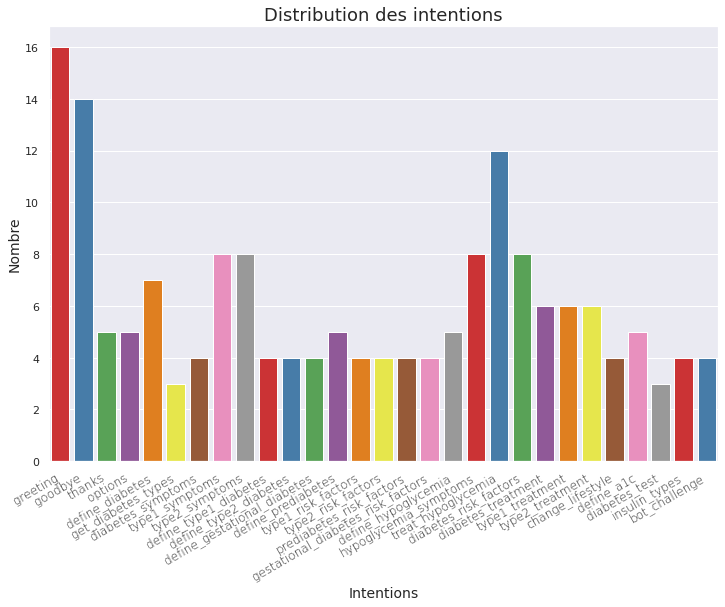

In [7]:
#La distribution en utilsant barplot
sns.set()
plt.figure(figsize = (12, 8))
chart = sns.countplot(x = 'intent', data = data, palette='Set1')
chart.set_xticklabels(chart.get_xticklabels(), rotation = 30, horizontalalignment='right', fontweight='light', fontsize='medium')
chart.set_title('Distribution des intentions', fontsize = 18)
chart.set_xlabel('Intentions', fontsize = 14)
chart.set_ylabel('Nombre', fontsize = 14)
plt.show()

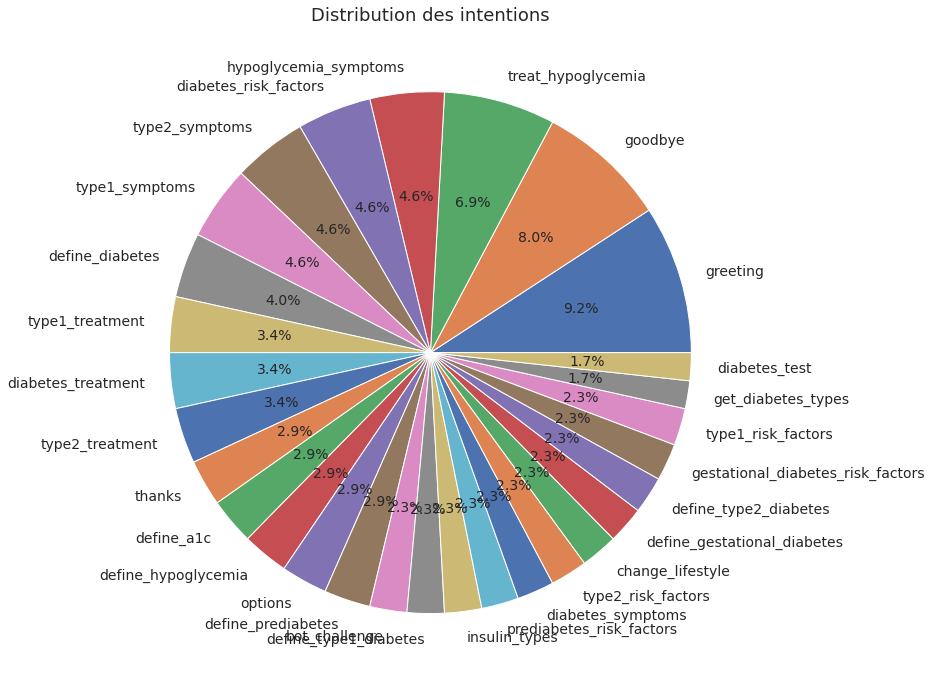

In [8]:
#La distribution en utilisant piechart
plt.figure(figsize = (12, 12))
dd = data.intent.value_counts()
explode = (0.1, 0, 0, 0, 0, 0, 0)
ax  = dd.plot.pie(autopct = '%1.1f%%', labels = dd.index, fontsize = 14)
ax.set_title('Distribution des intentions', fontsize = 18)
plt.axis('off')
#ax.legend(labels = dd.index, fontsize = 14, fancybox = True, labelspacing = 1, framealpha = 1, shadow=True, borderpad=1)
plt.show()

## En utilisant le modèle BERT
<br/><br/>
**BERT** c'est pour **B**idirectional **E**ncoder **R**epresentations from **T**ransformers. BERT est **pré-entraîné**, de façon **non supervisée** (initialement avec tout - absolument tout - le corpus anglophone de Wikipedia et BookCorpus), il possède une "représentation" linguistique qui lui est propre. Il est ensuite possible, sur la base de cette représentation initiale, de le customiser pour une tâche particulière. Il peut être entraîné en mode incrémental (de façon **supervisée** cette fois) pour spécialiser le modèle rapidement et avec peu de données.<br/><br/>
Ce qui est différent avec BERT, c'est qu'il peut lire l'entrée de texte dans les deux sens à la fois, contrairement aux autres modèles qui ne peuvent lire l'entrée que d'une manière séquentielle (de gauche à droite ou de droite à gauche).<br/><br/><br/>
[https://lesdieuxducode.com/blog/2019/4/bert--le-transformer-model-qui-sentraine-et-qui-represente][https://lesdieuxducode.com/blog/2019/4/bert--le-transformer-model-qui-sentraine-et-qui-represente] <br/>

[https://arxiv.org/pdf/1810.04805](https://arxiv.org/pdf/1810.04805)<br/>

[https://www.kdnuggets.com/2020/02/intent-recognition-bert-keras-tensorflow.html](https://www.kdnuggets.com/2020/02/intent-recognition-bert-keras-tensorflow.html)

In [61]:
!wget https://storage.googleapis.com/bert_models/2020_02_20/uncased_L-12_H-768_A-12.zip -P ./bert
!unzip ./bert/uncased_L-12_H-768_A-12.zip -d ./bert

--2021-06-13 21:21:02--  https://storage.googleapis.com/bert_models/2020_02_20/uncased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.19.144, 172.217.171.208, 172.217.171.240, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.19.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 408102251 (389M) [application/zip]
Saving to: ‘./bert/uncased_L-12_H-768_A-12.zip’

uncased_L-12_H-768_ 100%[===================>] 389.20M  1.27MB/s    in 5m 26s  

2021-06-13 21:26:29 (1.19 MB/s) - ‘./bert/uncased_L-12_H-768_A-12.zip’ saved [408102251/408102251]

Archive:  ./bert/uncased_L-12_H-768_A-12.zip
  inflating: ./bert/bert_model.ckpt.data-00000-of-00001  
  inflating: ./bert/bert_config.json  
  inflating: ./bert/vocab.txt        
  inflating: ./bert/bert_model.ckpt.index  


In [9]:
!cat bert/bert_config.json

{"hidden_size": 768, "hidden_act": "gelu", "initializer_range": 0.02, "vocab_size": 30522, "hidden_dropout_prob": 0.1, "num_attention_heads": 12, "type_vocab_size": 2, "max_position_embeddings": 512, "num_hidden_layers": 12, "intermediate_size": 3072, "attention_probs_dropout_prob": 0.1}

BERT-Base Uncased a: 12-layer, 768-hidden, 12-heads, 110M

In [51]:
modelInputFolder = './bert'
bert_model_name="uncased_L-12_H-768_A-12"
bert_ckpt_dir = "bert"#os.path.join(modelInputFolder, bert_model_name)
bert_ckpt_file = os.path.join(bert_ckpt_dir, "bert_model.ckpt")
bert_config_file = os.path.join(bert_ckpt_dir, "bert_config.json")
print(bert_ckpt_dir)
print(bert_ckpt_file)
print(bert_config_file) #bert_ckpt_file

bert
bert/bert_model.ckpt
bert/bert_config.json


In [11]:
tokenizer = FullTokenizer(vocab_file=os.path.join(bert_ckpt_dir, "vocab.txt"))

In [12]:
tokens = tokenizer.tokenize("What's the time in Morocco?")
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print(tokens)
print(token_ids)

['what', "'", 's', 'the', 'time', 'in', 'morocco', '?']
[2054, 1005, 1055, 1996, 2051, 1999, 9835, 1029]


In [13]:
tokenizer.convert_tokens_to_ids(tokenizer.tokenize("what"))

[2054]

In [45]:
class IntentDetectionData:
    DATA_COLUMN = "text" #feature
    LABEL_COLUMN = "intent" #label

    #max_seq_len represente la longueur maximale de l'entree/texte 
    #classes sont les intents 
    def __init__(self, train, test, tokenizer: FullTokenizer, classes, max_seq_len=512):
        self.tokenizer = tokenizer
        self.max_seq_len = 0
        self.classes = classes
        ((self.train_x, self.train_y), (self.test_x, self.test_y)) = map(self._prepare, [train, test])
        self.max_seq_len = min(self.max_seq_len, max_seq_len)
        self.train_x, self.test_x = map(self._pad, [self.train_x, self.test_x])


    #preparer les donnees : pretraitement
    def _prepare(self, df):
        x, y = [], []
        
        #recuperer les donnees
        #tqdm affiche une barre de progres : https://towardsdatascience.com/progress-bars-for-python-with-tqdm-4dba0d4cb4c#:~:text=tqdm%20is%20a%20Python%20library,time%20remaining%20for%20the%20iterable.
        for _, row in tqdm(df.iterrows()): 
            text, label = row[IntentDetectionData.DATA_COLUMN], row[IntentDetectionData.LABEL_COLUMN]

            #Tokeniser le texte 
            tokens = self.tokenizer.tokenize(text)

            #faut marquer le debut de la liste tokens par "CLS" et sa fin par "SEP"
            tokens = ["[CLS]"] + tokens + ["[SEP]"]

            #passer a une format numerique
            token_ids = self.tokenizer.convert_tokens_to_ids(tokens)

            #definir le max_seq_len
            self.max_seq_len = max(self.max_seq_len, len(token_ids))

            x.append(token_ids)
            y.append(self.classes.index(label))
            
        return np.array(x, dtype="object"), np.array(y, dtype="object")
    
    #padding in cnn : https://www.geeksforgeeks.org/cnn-introduction-to-padding/#:~:text=Padding%20is%20simply%20a%20process,%2B%202p)%20image%20after%20padding.
    def _pad(self, ids):
        x = []
        for input_ids in ids:
            input_ids = input_ids[:min(len(input_ids), self.max_seq_len - 2)]
            input_ids = input_ids + [0] * (self.max_seq_len - len(input_ids))
            x.append(np.array(input_ids))
        
        return np.array(x)

In [41]:
def create_model(max_seq_len, bert_ckpt_file):
    
    with tf.io.gfile.GFile(bert_config_file, "r") as reader:
        bc = StockBertConfig.from_json_string(reader.read())
        bert_params = map_stock_config_to_params(bc)
        bert_params.adapter_size = None
        bert = BertModelLayer.from_params(bert_params, name="bert")
        
    input_ids = keras.layers.Input(
        shape=(max_seq_len, ),
        dtype='int32',
        name="input_ids"
        )
    bert_output = bert(input_ids)
    print("bert shape", bert_output.shape)
    
    cls_out = keras.layers.Lambda(lambda seq: seq[:, 0, :])(bert_output)
    cls_out = keras.layers.Dropout(0.5)(cls_out)
    logits = keras.layers.Dense(units=768, activation="tanh")(cls_out)
    logits = keras.layers.Dropout(0.5)(logits)
    logits = keras.layers.Dense(
        units=len(classes),
        activation="softmax"
        )(logits)
        
    model = keras.Model(inputs=input_ids, outputs=logits)
    model.build(input_shape=(None, max_seq_len))
    load_stock_weights(bert, bert_ckpt_file)
    
    return model

In [52]:
data

,text,intent,responses
0,hey,greeting,"['Hello!', 'Good to see you', 'Hi there, how c..."
1,hello,greeting,"['Hello!', 'Good to see you', 'Hi there, how c..."
2,hi,greeting,"['Hello!', 'Good to see you', 'Hi there, how c..."
3,Hola,greeting,"['Hello!', 'Good to see you', 'Hi there, how c..."
4,hello there,greeting,"['Hello!', 'Good to see you', 'Hi there, how c..."
...,...,...,...
169,is all insulin the same,insulin_types,['There are four types of insulin that are mos...
170,are you a bot?,bot_challenge,"['I am a Melli, a chatbot']"
171,are you a human?,bot_challenge,"['I am a Melli, a chatbot']"
172,am I talking to a bot?,bot_challenge,"['I am a Melli, a chatbot']"


In [53]:
df = data[["text","intent"]].copy()

df

,text,intent
0,hey,greeting
1,hello,greeting
2,hi,greeting
3,Hola,greeting
4,hello there,greeting
...,...,...
169,is all insulin the same,insulin_types
170,are you a bot?,bot_challenge
171,are you a human?,bot_challenge
172,am I talking to a bot?,bot_challenge


In [54]:
df = df.sample(frac=1).reset_index(drop=True)

df

,text,intent
0,what's the cure of low blood sugar?,treat_hypoglycemia
1,is diabetes chronic,define_diabetes
2,how can I treat diabetes?,diabetes_treatment
3,bye bye,goodbye
4,what are the risks that may lead to Gestationa...,gestational_diabetes_risk_factors
...,...,...
169,is diabetes a disease,define_diabetes
170,hello,greeting
171,can you explain type 2 diabetes,define_gestational_diabetes
172,list the symptoms of diabetes,diabetes_symptoms


In [27]:
len(df)

174

In [19]:
train = df.iloc[:int(len(df)*0.85)]
test = df.iloc[int(len(df)*0.85):]

In [36]:
train

,text,intent
0,what is A1C test,define_a1c
1,what are the risks that may lead to Gestationa...,gestational_diabetes_risk_factors
2,what are the symptoms of hypoglycemia,hypoglycemia_symptoms
3,hello there,greeting
4,What's hypoglycemia?,define_hypoglycemia
...,...,...
142,what are the risk factors for Gestational diab...,gestational_diabetes_risk_factors
143,what is diabetes,define_diabetes
144,what factors lead to diabetes,diabetes_risk_factors
145,Good day,greeting


In [55]:
print(len(train["intent"].unique()))

29


In [56]:
data = IntentDetectionData(train, test, tokenizer, classes, max_seq_len=128)

147it [00:00, 2728.01it/s]
27it [00:00, 1759.41it/s]


In [57]:
data.train_x[0]

array([  101,  2054,  2024,  1996, 20390,  1997,  2828,  1015, 14671,
         102,     0,     0,     0,     0,     0,     0])

In [58]:
data.max_seq_len

16

In [59]:
model = create_model(data.max_seq_len, bert_ckpt_file)

bert shape (None, 16, 768)
Done loading 196 BERT weights from: bert/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7fcb3ac14070> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights


In [60]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 16)]              0         
_________________________________________________________________
bert (BertModelLayer)        (None, 16, 768)           108890112 
_________________________________________________________________
lambda_1 (Lambda)            (None, 768)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 768)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 768)               590592    
_________________________________________________________________
dropout_3 (Dropout)          (None, 768)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 29)                2230

In [61]:
model.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
)

In [64]:
_, train_acc = model.evaluate(np.array(data.train_x, dtype="float64"), np.array(data.train_y, dtype="float64"))
_, test_acc = model.evaluate(np.array(data.test_x, dtype="float64"), np.array(data.test_y, dtype="float64"))

print("train acc", train_acc)
print("test acc", test_acc)

1/1 [==============================] - 1s 1s/step - loss: 3.5495 - acc: 0.0370
train acc 0.03401360660791397
test acc 0.03703703731298447


## En utilisant la similarité textuelle  : Cosine Similarity 

La distance entre les mots : Angle entre les vecteurs<br/>
Nearest Neighbor classfication

In [20]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
import spacy
import pandas as pd
import numpy as np
from num2words import num2words
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import rc

In [21]:
dfc = pd.read_csv("data/intents.csv").sample(frac=1, random_state=42).reset_index(drop=True)
df2 = dfc[["text","intent"]]
nlp = spacy.load("en_core_web_md")
df2

,text,intent
0,what are some lifestyle changes that can help ...,change_lifestyle
1,how to deal with type 1 diabetes,type1_treatment
2,what are the factors for Gestational diabetes,gestational_diabetes_risk_factors
3,How to manage low blood sugar,treat_hypoglycemia
4,what's the cure of diabetes?,diabetes_treatment
...,...,...
169,define type 1 diabetes,define_type1_diabetes
170,what does hypoglycemia mean?,define_hypoglycemia
171,is anyone there?,greeting
172,what are the risk factors for type 2 diabetes,type2_risk_factors


In [22]:
nlp.vocab.vectors_length #la longueur d'un vecteur

300

In [23]:
doc = nlp("How can I help you?".lower())

for token in doc:
    print(token)

how
can
i
help
you
?


In [23]:
[token.lemma_ for token in doc]

['how', 'can', 'I', 'help', 'you', '?']

In [24]:
#preprocessing
def num_to_words(text):
	"""
	Return :- text which have all numbers or integers in the form of words
	Input :- string
	Output :- string
	"""
	# separer le texte en mots
	after_spliting = text.split()

	for index in range(len(after_spliting)):
		if after_spliting[index].isdigit():
			after_spliting[index] = num2words(after_spliting[index])

    # jogner la liste en une chaine de caracteres avec l'espace comme separateur
	numbers_to_words = ' '.join(after_spliting)
	return numbers_to_words

def wordvec(str):
    str = num_to_words(str)
    doc = nlp(str.lower())
    vec = doc.vector

    return vec

In [25]:
num_to_words("I'd like 2 apples")

"I'd like two apples"

In [25]:
vec = wordvec("how can i help you")

print(vec.size, '\n', vec[:5])

300 
 [-0.13755     0.37311798 -0.432832   -0.05158563 -0.005935  ]


In [26]:
classes = dfc.intent.unique().tolist()
df2['intent'] = df2['intent'].apply(classes.index)

<ipython-input-26-09cfca21a303>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['intent'] = df2['intent'].apply(classes.index)


In [10]:
df2['intent']

0       0
1       1
2       2
3       3
4       4
       ..
169    28
170    18
171     6
172    25
173     2
Name: intent, Length: 174, dtype: int64

In [27]:
dfc['intent']

0                       change_lifestyle
1                        type1_treatment
2      gestational_diabetes_risk_factors
3                     treat_hypoglycemia
4                     diabetes_treatment
                     ...                
169                define_type1_diabetes
170                  define_hypoglycemia
171                             greeting
172                   type2_risk_factors
173    gestational_diabetes_risk_factors
Name: intent, Length: 174, dtype: object

In [28]:
#Faire correspondre entre les labels numeriques et textuelles
val_label_cor = pd.concat(
    {
        "intent_val" : df2['intent'],
        "intent_label" : dfc['intent']
    },
    axis = 1
)

val_label_cor = val_label_cor.drop_duplicates().reset_index(drop=True)
val_label_cor

,intent_val,intent_label
0,0,change_lifestyle
1,1,type1_treatment
2,2,gestational_diabetes_risk_factors
3,3,treat_hypoglycemia
4,4,diabetes_treatment
5,5,define_diabetes
6,6,greeting
7,7,type2_symptoms
8,8,hypoglycemia_symptoms
9,9,type1_symptoms


In [29]:
X = np.stack(df2["text"].apply(wordvec).to_numpy(), axis=0)
y = df2.intent.to_numpy()

X_train = X[:int(0.6*X.shape[0])]
y_train = y[:int(0.6*y.shape[0])]
X_test = X[int(0.6*X.shape[0]):]
y_test = y[int(0.6*y.shape[0]):]
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, shuffle=None)

In [32]:
y_test

array([ 4,  4,  7, 26,  8,  8, 18, 10,  6,  0,  6, 20, 27, 17, 15, 22, 11,
        5,  6,  5, 28, 14,  8, 25, 24,  0, 23,  6,  6,  9, 20, 14, 12, 28,
       21, 14,  1, 20,  7,  9, 18, 10, 26,  9, 27, 23, 12,  9, 13, 14, 17,
       16,  6, 10, 21, 14, 21, 18,  2,  3, 23, 22,  3, 26, 12, 28, 18,  6,
       25,  2])

In [30]:
#X_train.shape[0]
labels_train = df2["intent"].iloc[:int(0.6*X.shape[0])]
labels_train

text_test = df2["text"].iloc[int(0.6*X.shape[0]):]

In [31]:
np.unique(labels_train).shape

(29,)

In [32]:
#returns 
def nearest(X_train, y_train,X_test):
    y_pred_labels = []
    y_pred_vals = []
    for x in X_test:
        scores = [cosine_similarity(X_train[i,:].reshape(1,-1), x.reshape(1,-1)) for i in range(X_train.shape[0])]
        max_idx = np.argmax(scores)
        y_pred_vals.append(y_train[max_idx])
        #y_pred_labels.append(labels_train[max_idx])

    return y_pred_vals#, y_pred_labels


In [33]:
test_vals_pred = nearest(X_train,y_train, X_test)
#test_labels_true = df2["intent"].iloc[int(0.6*y.shape[0]):]

In [34]:
print(len(test_vals_pred), "\n", test_vals_pred)

70 
 [24, 4, 7, 26, 8, 8, 20, 7, 6, 0, 12, 20, 27, 17, 22, 15, 11, 5, 18, 5, 1, 19, 8, 14, 5, 0, 25, 6, 6, 7, 20, 19, 6, 22, 1, 19, 1, 20, 9, 9, 20, 8, 26, 7, 27, 25, 12, 7, 13, 14, 17, 19, 6, 9, 1, 19, 21, 3, 14, 3, 14, 21, 3, 17, 12, 22, 5, 17, 25, 19]


In [35]:
cmp = pd.DataFrame.from_dict(
    {
        "text" : text_test,
        "vrai label" : y_test,
        "label predit" : test_vals_pred
    }
)

cmp

,text,vrai label,label predit
104,How to manage diabetes,4,24
105,what is the best treatment for diabetes?,4,4
106,what are the symptoms of type 2 diabetes,7,7
107,am I talking to a bot?,26,26
108,list the symptoms of hypoglycemia,8,8
...,...,...,...
169,define type 1 diabetes,28,22
170,what does hypoglycemia mean?,18,5
171,is anyone there?,6,17
172,what are the risk factors for type 2 diabetes,25,25


In [36]:
#scores
print("precision_score_micro = ",precision_score(y_test, test_vals_pred, average='micro'))
print("precision_score_macro = ",precision_score(y_test, test_vals_pred, average='macro'))
print("recall_score_micro = ", recall_score(y_test, test_vals_pred, average="micro"))
print("f1_score_micro = ",f1_score(y_test, test_vals_pred, average="micro"))

precision_score_micro =  0.4714285714285714
precision_score_macro =  0.4258620689655172
recall_score_micro =  0.4714285714285714
f1_score_micro =  0.4714285714285714
/home/rahima/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [42]:
cm = confusion_matrix(y_test, test_vals_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)

Text(0.5, 86.09375, 'Label predit')

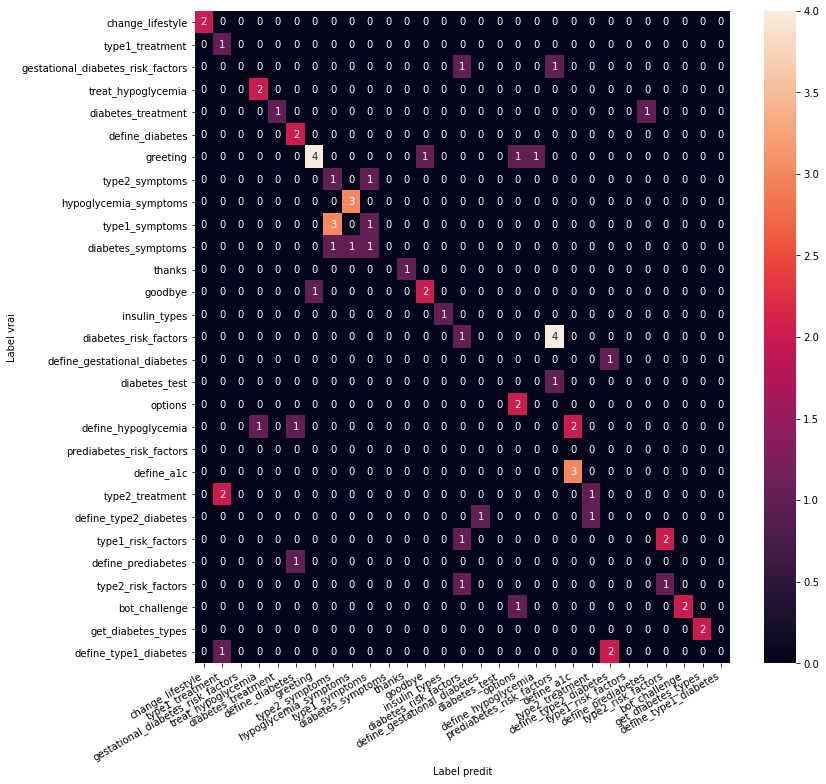

In [43]:
plt.figure(figsize = (12, 12))
hmap = sns.heatmap(df_cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('Label vrai')
plt.xlabel('Label predit')

In [44]:
#from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

In [45]:
clf = SVC(C=1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(y_pred)
print(y_test)

[ 3  3  7 12  7  3  3  7 12  3 12  3  7 12  7  7 12  5 12  5  1  7  7  7
  5  3  7  6 12  7  3  7 12  7  1  7  1  3  7  7  3  7  3  7  7  7 12  7
  7  3 12  7  6  7  7  7  7  3  3  3  7  1  3 12 12  1  3 12  7  3]
[ 4  4  7 26  8  8 18 10  6  0  6 20 27 17 15 22 11  5  6  5 28 14  8 25
 24  0 23  6  6  9 20 14 12 28 21 14  1 20  7  9 18 10 26  9 27 23 12  9
 13 14 17 16  6 10 21 14 21 18  2  3 23 22  3 26 12 28 18  6 25  2]


In [46]:
print("precision_score_micro = ",precision_score(y_test, y_pred, average='micro'))
print("precision_score_macro = ",precision_score(y_test, y_pred, average='macro'))

precision_score_micro =  0.17142857142857143
precision_score_macro =  0.08133973306387099
/home/rahima/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## En utilisant un réseau neurone 

In [16]:
import nltk
from nltk.stem import WordNetLemmatizer
import json
import pickle
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers import SGD
import pandas as pd
import spacy
import random

In [2]:
lemmatizer = WordNetLemmatizer()

In [4]:
words=[]
classes = []
documents = []
ignore_words = ['?', '!']
data_file = open('data/intents.json').read()
intents = json.loads(data_file)

In [6]:
for intent in intents['intents']:
    for pattern in intent['patterns']:

        #tokenize each word
        w = nltk.word_tokenize(pattern)
        words.extend(w)
        #add documents in the corpus
        documents.append((w, intent['tag']))

        # add to our classes list
        if intent['tag'] not in classes:
            classes.append(intent['tag'])

In [11]:
lemmatizer = WordNetLemmatizer()

In [13]:
words = [lemmatizer.lemmatize(w.lower()) for w in words if w not in ignore_words]
words = sorted(list(set(words)))

In [ ]:
classes = dfc.intent.unique().tolist()
df0['intent'] = df0['intent'].apply(classes.index)

In [37]:
data0 = dfc.copy()
df0 = data0[["text","intent"]]

df0

,text,intent
0,what are some lifestyle changes that can help ...,change_lifestyle
1,how to deal with type 1 diabetes,type1_treatment
2,what are the factors for Gestational diabetes,gestational_diabetes_risk_factors
3,How to manage low blood sugar,treat_hypoglycemia
4,what's the cure of diabetes?,diabetes_treatment
...,...,...
169,define type 1 diabetes,define_type1_diabetes
170,what does hypoglycemia mean?,define_hypoglycemia
171,is anyone there?,greeting
172,what are the risk factors for type 2 diabetes,type2_risk_factors


In [41]:
#preparer les donnees 

y_train = y_train.tolist()
y_test = y_test.tolist()

29

In [48]:
#preparer les labels
arr = [1,2,3,4]
def to_vec(val):
    vec = [0] * len(classes)
    vec[val] = 1
    return vec

y_train = np.array(list(map(to_vec, y_train)))
y_test = np.array(list(map(to_vec, y_test)))

array([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0]])

In [ ]:
#Definissons un modele sequentiel Keras de 3 couches

model = Sequential()
model.add(Dense(300, input_dim=300, activation='relu')) #dim des vecteurs vaut 300
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


In [38]:
#On va utiliser les X_train, y_train, X_test, y_train predifinis



array([[-0.0453644 ,  0.3169443 , -0.21708198, ..., -0.1891264 ,
         0.18365641,  0.0546895 ],
       [-0.07383614,  0.26024458, -0.25776714, ..., -0.15591958,
         0.1762557 ,  0.21817572],
       [-0.11541114,  0.3906389 , -0.28178144, ..., -0.13607715,
         0.14310429,  0.01331428],
       ...,
       [-0.13132316,  0.3140583 , -0.36447334, ..., -0.16067784,
         0.35866055,  0.08296333],
       [-0.22044401,  0.36224666, -0.21723334, ..., -0.06895867,
        -0.33893064,  0.29439333],
       [-0.31345174,  0.341247  , -0.16532287, ..., -0.28896752,
         0.16738252,  0.21004698]], dtype=float32)

In [40]:
y_train

array([ 0,  1,  2,  3,  4,  4,  5,  6,  3,  7,  8,  9,  5, 10, 11,  6,  8,
        9, 12,  0,  4, 13, 14, 12,  9,  5,  8, 12, 12, 15, 11, 12,  6,  7,
        3,  3,  1, 16, 17,  4, 18,  7,  1,  6, 19, 20, 21, 22,  8, 12, 21,
       23,  8,  7, 17, 24, 12,  1, 19,  7, 13,  6, 19, 22,  6, 12, 24,  6,
       11, 25,  3, 16,  6, 26,  3,  6, 14,  3,  7,  5, 19, 12,  5,  3, 12,
       12, 21, 15, 15, 24, 17,  2, 24,  3, 13,  1, 27, 25, 14, 20,  9, 28,
       11,  3])